### INFO284 Machine Learning exam, spring 2024
by ppa007 and ....
delievered 30.4.2024

#### Import and version control for relevant libraries.

We are working with the following versions:
- Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
- pandas version: 2.2.1
- matplotlib version: 3.8.3
- NumPy version: 1.26.4
- SciPy version: 1.12.0
- IPython version: 8.21.0
- scikit-learn version: 1.4.1.post1
- seaborn version: 0.13.2

In [582]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
pandas version: 2.2.1
matplotlib version: 3.8.3
NumPy version: 1.26.4
SciPy version: 1.12.0
IPython version: 8.21.0
scikit-learn version: 1.4.1.post1
seaborn version: 0.13.2


#### Import of the dataset
The file is encoded in UTF-8, so it will only work if you have the correct version of pandas.

In [583]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")

In [584]:
def status_dataframe(dataframe):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    print(f"The dataset now has {dataframe.shape[1]} columns and {dataframe.shape[0]} rows")
    display(dataframe.head(5))
    dataframe.info()

status_dataframe(df)

The dataset now has 45 columns and 305434 rows


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305434 entries, 0 to 305433
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                305434 non-null  int64  
 1   Meldingstidspunkt         305434 non-null  object 
 2   Meldingsdato              305434 non-null  object 
 3   Meldingsklokkeslett       305434 non-null  object 
 4   Starttidspunkt            305434 non-null  object 
 5   Startdato                 305434 non-null  object 
 6   Startklokkeslett          305434 non-null  object 
 7   Startposisjon bredde      305434 non-null  object 
 8   Startposisjon lengde      305434 non-null  object 
 9   Hovedområde start (kode)  303433 non-null  float64
 10  Hovedområde start         301310 non-null  object 
 11  Lokasjon start (kode)     303433 non-null  float64
 12  Havdybde start            305434 non-null  int64  
 13  Stopptidspunkt            305434 non-null  o

### Choice of targets and preprocessing
Our chosen target variables are the catches of haddock, cod, and pollock(hyse, torsk and sei) as continuous values. This means that it is a combination of the columns 'Art FAO,' which indicates the captured species, and 'Rundvekt,' which indicates the weight of the catch. Due to our target being a continuous value we will retain the feature with continuous values when two features are representing the same thing.

We will use a consistent seed to make the results from the various models more comparable, only randomising it in later stages and when validating.

All the featuers and targets will be refered to by their norwegian names.

In [585]:
seed = 32

#### Removing rows and columns

Rows:
- We remove all rows that are about other species than our target.
- We check the amount of nan values in columns. Columns with high frequency of nan values are processed later while the low frequency columns have their rows removed.

In [586]:
df = df[df['Art FAO'].isin(['Torsk', 'Sei', 'Hyse'])]

In [587]:
df.isnull().sum()

Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)       387
Hovedområde start              912
Lokasjon start (kode)          387
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)       373
Hovedområde stopp              912
Lokasjon stopp (kode)          373
Havdybde stopp                   0
Trekkavstand                     4
Redskap FAO (kode)               0
Redskap FAO                    165
Redskap FDIR (kode)            165
Redskap FDIR        

In [588]:
exclude_columns = ['Bruttotonnasje 1969', 'Bruttotonnasje annen']
nan_count = df.drop(exclude_columns, axis=1).isnull().any(axis=1).sum()
print(f"There are {nan_count} rows with nan valeus.")

There are 1143 rows with nan valeus.


In [589]:
df.dropna(subset=[col for col in df.columns if col not in exclude_columns], inplace = True)
df.isnull().sum()

Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)         0
Hovedområde start                0
Lokasjon start (kode)            0
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)         0
Hovedområde stopp                0
Lokasjon stopp (kode)            0
Havdybde stopp                   0
Trekkavstand                     0
Redskap FAO (kode)               0
Redskap FAO                      0
Redskap FDIR (kode)              0
Redskap FDIR        

Columns(part 1):
- "Fangstår": The dataset is from 2018, but it contains some reports from 2017 as they were reported after New Year's Eve. We remove it because it only contains 2 unique values, where over 99% of them are just one of them.
- "Feature" and "Feature (kode)" are in nearly all instances the same information. We retain the categorical "Feature" because it is more human readable, removing the "Feature (kode)".
- "Hovedområde stopp (kode)" is the exception. By comparing it with "Hovedområde start", which has 1:1 relation with it's (kode) equivalent, we find that the highest frequency code in "Hovedområde stopp (kode)" for each entry in "Hovedområde stopp" overlaps 98 % of the time. From this we conclude it's a mistake in registration.
- Ship information(Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde) represent nearly the same thing in different ways. We prove this by: (A) showing that with "Bruttotonnasje 1969" and "Bruttotonnasje annen" usually one column holds value while the other one is emtpy and visa versa. The columns are combined, priority given to "Bruttotonnasje 1969" due to that being a specific standard while "Bruttotonnasje annen" is not. Nan values are removed. (B) "Fartøylengde" is a more nuanced category of "Lengdegruppe". (C) "Fartøylengde", "Bredde" and "Bruttotonnasje" have a strong correlation. After proving this we choose to retain "Bruttotonnasje", which represents a ships max carrying capacity, as it seems the most relevant with regards to our target value being the weight of a catch.

In [590]:
value_counts = df['Fangstår'].value_counts()
print(value_counts)
df.drop(columns = ['Fangstår'], inplace= True)

Fangstår
2018    137097
2017        11
Name: count, dtype: int64


In [591]:
def test_similarity(dataframe, feature1, feature2):
    value_counts = dataframe.groupby([feature1, feature2]).size().unstack(fill_value=0)

    value_summary = {}

    for column in value_counts.columns:
        value_summary.setdefault(column, [])
        value_summary[column].extend(list(zip(
            value_counts.index[value_counts[column] != 0].tolist(),
            value_counts[value_counts[column] != 0][column].tolist()
        )))
    mismatched_values = []

    key_value_count = {key: len(value) for key, value in value_summary.items()}
    for key, value in key_value_count.items():
        if value > 1:
            mismatched_values.append(key)


    used_feature2_keys = [key for key in value_summary.keys()]

    feature2_keys = list(feature2.unique())

    unused_feature2_keys = []
    for x in feature2_keys:
        if x not in used_feature2_keys:
            unused_feature2_keys.append(x)
         
            
    used_feature1_keys = []

    for tupple_list in value_summary.values():
        for tupple in tupple_list:
            used_feature1_keys.append(tupple[0])

    feature1_keys = list(feature1.unique())

    unused_feature1_keys = []
    for x in feature1_keys:
        if x not in used_feature1_keys:
            unused_feature1_keys.append(x)

    if len(unused_feature2_keys) > 0:
        print(f"Values in {feature2.name} which have no value in {feature1.name}: {unused_feature2_keys}")
    if len(unused_feature1_keys) > 0:
        print(f"Values in {feature1.name} which have no value in {feature2.name}: {unused_feature1_keys}")



    if len(mismatched_values) > 0:
        print(f"These values in {feature2.name} aren't the same in {feature1.name}: {mismatched_values}.")
        return value_summary
    
    print(f"The values of {feature2.name} and {feature1.name} represent the same thing.") 
    # Returns a dictonary where the keys are values in feature2 and the values are tupples with the values of feature1 and a count of their frequency.
    return value_summary
   

In [592]:
dictionary_summary = test_similarity(df, df["Redskap FAO"], df["Redskap FAO (kode)"])
# print(dictionary_summary)

The values of Redskap FAO (kode) and Redskap FAO represent the same thing.


In [593]:
dictionary_summary = test_similarity(df, df["Redskap FDIR"], df["Redskap FDIR (kode)"])
# print(dictionary_summary)

The values of Redskap FDIR (kode) and Redskap FDIR represent the same thing.


In [594]:
dictionary_summary = test_similarity(df, df["Hovedart FAO"], df["Hovedart FAO (kode)"])
# print(dictionary_summary)

The values of Hovedart FAO (kode) and Hovedart FAO represent the same thing.


In [595]:
dictionary_summary = test_similarity(df, df["Art FAO"], df["Art FAO (kode)"])
# print(dictionary_summary)

The values of Art FAO (kode) and Art FAO represent the same thing.


In [596]:
dictionary_summary = test_similarity(df, df["Art - FDIR (kode)"], df["Art - FDIR"])
# print(dictionary_summary)

The values of Art - FDIR and Art - FDIR (kode) represent the same thing.


In [597]:
dictionary_summary = test_similarity(df, df["Art - gruppe (kode)"], df["Art - gruppe"])
# print(dictionary_summary)

The values of Art - gruppe and Art - gruppe (kode) represent the same thing.


In [598]:
dictionary_summary = test_similarity(df, df["Lengdegruppe (kode)"], df["Lengdegruppe"])
# print(dictionary_summary)

The values of Lengdegruppe and Lengdegruppe (kode) represent the same thing.


In [599]:
dictionary_summary = test_similarity(df, df["Hovedområde start (kode)"], df["Hovedområde start"])
print('\n')
# print(dictionary_summary)


mismatched_dictionary = test_similarity(df, df["Hovedområde stopp (kode)"], df["Hovedområde stopp"])

print('\n')
feature1_value_count = {}
for key, tuples in mismatched_dictionary.items():
    largest_count = max(tuples, key=lambda x: x[1])
    feature1_value_count[key] = largest_count

feature2_value_count = {}
for key, value in dictionary_summary.items():
    feature2_value_count[key] = value[0]

same_code_count = 0

for key in feature1_value_count.keys():
    if key in feature2_value_count:
        feature1_code = feature1_value_count[key][0]
        feature2_code = feature2_value_count[key][0]
        if feature1_code == feature2_code:
            same_code_count += 1
        else:
            print(f"The area '{key}' has two different highest frequency codes: '{feature1_code}' and '{feature2_code}'.")
percentage = (same_code_count / len(mismatched_dictionary)) * 100
print(f"'Hovedområde start' and 'Hovedområde stopp' have the same highest frequency code in {percentage} % of instances. ")

The values of Hovedområde start and Hovedområde start (kode) represent the same thing.


These values in Hovedområde stopp aren't the same in Hovedområde stopp (kode): ['Admiralityfeltet', 'Bjørnøya', 'Britvinfeltet', 'Eigersundbanken', 'Færøybanken', 'Gåsebanken', 'Helgelandsbanken', 'Hopen', 'Kaninbanken', 'Murmanskkysten', 'Nordkappbanken', 'Nordøstområdet', 'Rockall', 'Røstbanken til Malangsgrunnen', 'Sentralbanken', 'Sentrale Nordsjø', 'Shetland', 'Skagerrak', 'Skolpenbanken', 'Storbanken', 'Storegga-Frøyabanken', 'Storfjord/Hinlopenstredet', 'Sørlige Norskehav', 'Sørvest av Spitsbergen', 'Thor Iversens Bank', 'Vest av Færøyene', 'Vest av Skottland (Hebridene)', 'Vest av Tromsøflaket', 'Vest-Finnmark', 'Vest-Spitsbergen', 'Vestfjorden (Lofoten)', 'Vikingbanken', 'Øst av Færøyene', 'Øst-Finnmark', 'Østlige Norskehav'].


The area 'Sørvest av Spitsbergen' has two different highest frequency codes: '20.0' and '27.0'.
'Hovedområde start' and 'Hovedområde stopp' have the same highest f

In [600]:
df.drop(columns=["Hovedområde start (kode)", "Hovedområde stopp (kode)", "Redskap FAO (kode)", "Redskap FDIR (kode)", "Hovedart FAO (kode)",
                 "Art FAO (kode)","Art - FDIR (kode)", "Art - gruppe (kode)", "Lengdegruppe (kode)"], inplace=True)

In [601]:
b_nan = df['Bruttotonnasje 1969'].notnull() & df['Bruttotonnasje annen'].isnull()
a_nan = df['Bruttotonnasje annen'].notnull() & df['Bruttotonnasje 1969'].isnull()
both = df['Bruttotonnasje annen'].notnull() & df['Bruttotonnasje 1969'].notnull()
both_nan = df['Bruttotonnasje 1969'].isnull() & df['Bruttotonnasje annen'].isnull()

print(f"""Rows where only 'Bruttotonnasje 1969' has values: {b_nan.sum()}
Rows where only 'Bruttotonnasje annen' has values: {a_nan.sum()}
Rows where both columns have values: {both.sum()}
Rows where both columns have nan values: {both_nan.sum()}""")

df['Bruttotonnasje'] = df['Bruttotonnasje 1969'].combine_first(df['Bruttotonnasje annen'])

Rows where only 'Bruttotonnasje 1969' has values: 101475
Rows where only 'Bruttotonnasje annen' has values: 32433
Rows where both columns have values: 2479
Rows where both columns have nan values: 721


In [602]:
df['Fartøylengde'] = df['Fartøylengde'].str.replace(',', '.').astype(float)
df['Bredde'] = df['Bredde'].str.replace(',', '.').astype(float)

In [603]:
min_max_values = df.groupby('Lengdegruppe')['Fartøylengde'].agg(['min', 'max'])
print(min_max_values)

                min    max
Lengdegruppe              
15-20,99 m    15.01  20.99
21-27,99 m    21.07  27.99
28 m og over  28.10  81.20


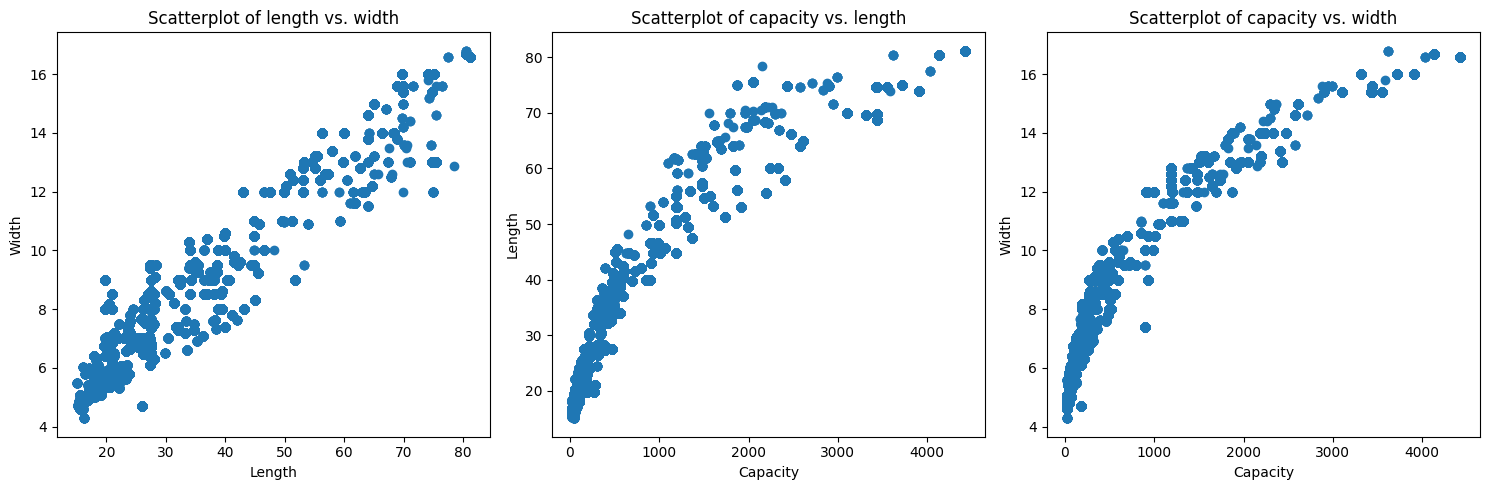

Correlation coefficient between Fartøylengde and Bredde: 0.9523647363657679
Correlation coefficient between Fartøylengde and Bruttotonnasje: 0.9358894651847561
Correlation coefficient between Bruttotonnasje and Bredde: 0.9304178899226285


In [604]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(df['Fartøylengde'], df['Bredde'])
axs[0].set_xlabel('Length')
axs[0].set_ylabel('Width')
axs[0].set_title('Scatterplot of length vs. width')

axs[1].scatter(df['Bruttotonnasje'], df['Fartøylengde'])
axs[1].set_xlabel('Capacity')
axs[1].set_ylabel('Length')
axs[1].set_title('Scatterplot of capacity vs. length')

axs[2].scatter(df['Bruttotonnasje'], df['Bredde'])
axs[2].set_xlabel('Capacity')
axs[2].set_ylabel('Width')
axs[2].set_title('Scatterplot of capacity vs. width')

plt.tight_layout()

plt.show()

correlation = df['Fartøylengde'].corr(df['Bredde'])
print(f"Correlation coefficient between {df['Fartøylengde'].name} and {df['Bredde'].name}:", correlation)
correlation = df['Fartøylengde'].corr(df['Bruttotonnasje'])
print(f"Correlation coefficient between {df['Fartøylengde'].name} and {df['Bruttotonnasje'].name}:", correlation)
correlation = df['Bruttotonnasje'].corr(df['Bredde'])
print(f"Correlation coefficient between {df['Bruttotonnasje'].name} and {df['Bredde'].name}:", correlation)

In [605]:
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)
df = df.dropna()
status_dataframe(df)

The dataset now has 31 columns and 136387 rows


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO,Redskap FDIR,Hovedart FAO,Hovedart - FDIR (kode),Art FAO,Art - FDIR,Art - gruppe,Rundvekt,Bruttotonnasje
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9594.0,1476.0
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,8510.0,1476.0
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",Bjørnøya,7.0,-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Sei,Sei,Sei,134.0,1476.0
5,1497178,01.01.2018,01.01.2018,00:00,31.12.2017 05:48,31.12.2017,05:48,"74,91","15,868",Bjørnøya,7.0,-403,31.12.2017 10:15,31.12.2017,10:15,267,"74,901","16,248",Bjørnøya,7.0,-277,11096.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9118.0,1476.0
6,1497178,01.01.2018,01.01.2018,00:00,31.12.2017 05:48,31.12.2017,05:48,"74,91","15,868",Bjørnøya,7.0,-403,31.12.2017 10:15,31.12.2017,10:15,267,"74,901","16,248",Bjørnøya,7.0,-277,11096.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,6651.0,1476.0


<class 'pandas.core.frame.DataFrame'>
Index: 136387 entries, 1 to 305428
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Melding ID              136387 non-null  int64  
 1   Meldingstidspunkt       136387 non-null  object 
 2   Meldingsdato            136387 non-null  object 
 3   Meldingsklokkeslett     136387 non-null  object 
 4   Starttidspunkt          136387 non-null  object 
 5   Startdato               136387 non-null  object 
 6   Startklokkeslett        136387 non-null  object 
 7   Startposisjon bredde    136387 non-null  object 
 8   Startposisjon lengde    136387 non-null  object 
 9   Hovedområde start       136387 non-null  object 
 10  Lokasjon start (kode)   136387 non-null  float64
 11  Havdybde start          136387 non-null  int64  
 12  Stopptidspunkt          136387 non-null  object 
 13  Stoppdato               136387 non-null  object 
 14  Stoppklokkeslett        1

Columns(part 2):
- Hovedområde start ,Lokasjon start (kode), Hovedområde stopp, Lokasjon stopp (kode): beskrives i (ref 1) som "Dette er en beregnet verdi fra system med bakgrunn i posisjoner som fisker oppgir i innrapporteringen i fangstmeldingen." Noe som betyr at bredde og lengde grader for start og stopp-posisjon resprsenterer samme informasjon som en mer nyansert kontinuerlig verdi. Vi dropper derfor disse kolonnene.

In [606]:
df.drop(columns=["Hovedområde start", "Lokasjon start (kode)", "Hovedområde stopp", "Lokasjon stopp (kode)"], inplace=True)
status_dataframe(df)

The dataset now has 27 columns and 136387 rows


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Redskap FDIR,Hovedart FAO,Hovedart - FDIR (kode),Art FAO,Art - FDIR,Art - gruppe,Rundvekt,Bruttotonnasje
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9594.0,1476.0
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,8510.0,1476.0
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017 04:16,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Sei,Sei,Sei,134.0,1476.0
5,1497178,01.01.2018,01.01.2018,00:00,31.12.2017 05:48,31.12.2017,05:48,"74,91","15,868",-403,31.12.2017 10:15,31.12.2017,10:15,267,"74,901","16,248",-277,11096.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Hyse,Hyse,Hyse,9118.0,1476.0
6,1497178,01.01.2018,01.01.2018,00:00,31.12.2017 05:48,31.12.2017,05:48,"74,91","15,868",-403,31.12.2017 10:15,31.12.2017,10:15,267,"74,901","16,248",-277,11096.0,"Bunntrål, otter",Bunntrål,Hyse,1027.0,Torsk,Torsk,Torsk,6651.0,1476.0


<class 'pandas.core.frame.DataFrame'>
Index: 136387 entries, 1 to 305428
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Melding ID              136387 non-null  int64  
 1   Meldingstidspunkt       136387 non-null  object 
 2   Meldingsdato            136387 non-null  object 
 3   Meldingsklokkeslett     136387 non-null  object 
 4   Starttidspunkt          136387 non-null  object 
 5   Startdato               136387 non-null  object 
 6   Startklokkeslett        136387 non-null  object 
 7   Startposisjon bredde    136387 non-null  object 
 8   Startposisjon lengde    136387 non-null  object 
 9   Havdybde start          136387 non-null  int64  
 10  Stopptidspunkt          136387 non-null  object 
 11  Stoppdato               136387 non-null  object 
 12  Stoppklokkeslett        136387 non-null  object 
 13  Varighet                136387 non-null  int64  
 14  Stopposisjon bredde     1

- Hovedart FAO og Hovedart - FDIR (kode): beskrives i (ref 1) som "Art som det er fisket mest av i følge innrapporteringen." Det er da en variabelt aveldet av vår mål variabel og innholder informasjon om vår målvariabel i tillegg til at den representerer informasjon som ikke er tilgjengelig i forkant av hendelsen. Derfor fjernes den.


In [607]:
df.drop(columns=["Hovedart FAO", "Hovedart - FDIR (kode)"], inplace = True)

- Redskap FAO, Redskap FDIR, Art FAO, Art - FDIR, Art - gruppe: Forkortelsene står for FAO = Food and Agriculture Organization of the United Nations , FDIR = Fiskeridirektoratet og gruppe = "nokre er slått saman og vises som gruppe. Bakgrunnen for at vi har valt å innføre dette nivået er at nokre av artane i Fiskeridirektoratets kodeliste vert brukt ulikt av dei ulike fiskesalslaga."(ref 2). Dette betyr at dette er samme informasjon, bare med forskjellige koder. For vårt formål ønsker vi å holde oss innenfor en kategoriseringsmetode med den høyeste nyanseringen og velger derfor å beholde Redskap FAO og Art FAO

In [608]:
utskrift = test_similarity(df, df["Redskap FDIR"], df["Redskap FAO"])
print(utskrift)
print(len(utskrift))


The values of Redskap FAO and Redskap FDIR represent the same thing.
{'Andre liner': [('Andre liner', 9044)], 'Annen trål (udefinert)': [('Udefinert trål', 30)], 'Boat /vessel seines -Pair seines': [('Snurrevad', 299)], 'Bunntrål (uspes)': [('Udefinert trål', 2751)], 'Bunntrål, otter': [('Bunntrål', 58226)], 'Bunntrål, par': [('Bunntrål par', 1110)], 'Bunntrål, reke': [('Reketrål', 5483)], 'Encircling gillnets*': [('Udefinert garn', 192)], 'Flytetrål, otter': [('Flytetrål', 199)], 'Flytetrål, par': [('Flytetrål par', 230)], 'Flytetrål, uspesifisert': [('Udefinert trål', 331)], 'Gillnets and entangling nets (unspec)*': [('Udefinert garn', 6297)], 'Juksa/pilk, manuell': [('Juksa/pilk', 19)], 'Otter dobbeltrål': [('Dobbeltrål', 1073)], 'Partrål, uspesifisert': [('Udefinert trål', 126)], 'Settegarn': [('Settegarn', 377)], 'Setteline': [('Andre liner', 7288)], 'Snurpenot/ringnot': [('Snurpenot/ringnot', 529)], 'Snurpenot/ringnot, et fartøy': [('Snurpenot/ringnot', 1253)], 'Snurpenot/ringnot

In [609]:
utskrift = test_similarity(df, df["Art - FDIR"], df["Art FAO"])
print(utskrift)
print(len(utskrift))

The values of Art FAO and Art - FDIR represent the same thing.
{'Hyse': [('Hyse', 38735)], 'Sei': [('Sei', 41903)], 'Torsk': [('Torsk', 55749)]}
3


In [610]:
utskrift = test_similarity(df, df["Art - gruppe"], df["Art FAO"])
print(utskrift)
print(len(utskrift))

The values of Art FAO and Art - gruppe represent the same thing.
{'Hyse': [('Hyse', 38735)], 'Sei': [('Sei', 41903)], 'Torsk': [('Torsk', 55749)]}
3


In [611]:
df.drop(columns= ["Redskap FDIR", "Art - FDIR", "Art - gruppe"], inplace = True)

- Melding ID, Meldingstidspunkt, Meldingsdato, Meldingsklokkeslett: Representerer informasjon som ikke har noen relasjon til hendelsen tillegg til at den representerer informasjon som ikke er tilgjengelig i forkant av hendelsen. Melding ID blir beholdt til vi har gruppert dataframen på nytt og så fjernes den, resten blir nå fjernet.

In [612]:
df.drop(columns= ["Meldingstidspunkt", "Meldingsdato", "Meldingsklokkeslett"], inplace = True)

- Starttidspunkt og Stopptidspunkt: er en avledet av variablene for dato og klokkeslett for start og stopp og vil derfor bli fjernet.

In [613]:
df['Sta_dato'] = df['Starttidspunkt'].str[:10]
df['Sta_tid'] = df['Starttidspunkt'].str[12:]
df['Sto_dato'] = df['Stopptidspunkt'].str[:10]
df['Sto_tid'] = df['Stopptidspunkt'].str[12:]

In [614]:
utskrift = test_similarity(df, df["Sta_dato"], df["Startdato"])

The values of Startdato and Sta_dato represent the same thing.


In [615]:
utskrift = test_similarity(df, df["Sta_tid"], df["Startklokkeslett"])

The values of Startklokkeslett and Sta_tid represent the same thing.


In [616]:
utskrift = test_similarity(df, df["Sto_dato"], df["Stoppdato"])

The values of Stoppdato and Sto_dato represent the same thing.


In [617]:
utskrift = test_similarity(df, df["Sto_tid"], df["Stoppklokkeslett"])

The values of Stoppklokkeslett and Sto_tid represent the same thing.


In [618]:
df.drop(columns = ["Sto_tid", "Sto_dato", "Sta_tid", "Sta_dato", "Starttidspunkt", "Stopptidspunkt"], inplace = True)

In [619]:
status_dataframe(df)

The dataset now has 17 columns and 136387 rows


,Melding ID,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Havdybde start,Stoppdato,Stoppklokkeslett,Varighet,Stopposisjon bredde,Stopposisjon lengde,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Bruttotonnasje
1,1497178,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Hyse,9594.0,1476.0
2,1497178,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Torsk,8510.0,1476.0
4,1497178,30.12.2017,23:21,"74,885","16,048",-335,31.12.2017,04:16,295,"74,914","15,969",-334,3970.0,"Bunntrål, otter",Sei,134.0,1476.0
5,1497178,31.12.2017,05:48,"74,91","15,868",-403,31.12.2017,10:15,267,"74,901","16,248",-277,11096.0,"Bunntrål, otter",Hyse,9118.0,1476.0
6,1497178,31.12.2017,05:48,"74,91","15,868",-403,31.12.2017,10:15,267,"74,901","16,248",-277,11096.0,"Bunntrål, otter",Torsk,6651.0,1476.0


<class 'pandas.core.frame.DataFrame'>
Index: 136387 entries, 1 to 305428
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Melding ID            136387 non-null  int64  
 1   Startdato             136387 non-null  object 
 2   Startklokkeslett      136387 non-null  object 
 3   Startposisjon bredde  136387 non-null  object 
 4   Startposisjon lengde  136387 non-null  object 
 5   Havdybde start        136387 non-null  int64  
 6   Stoppdato             136387 non-null  object 
 7   Stoppklokkeslett      136387 non-null  object 
 8   Varighet              136387 non-null  int64  
 9   Stopposisjon bredde   136387 non-null  object 
 10  Stopposisjon lengde   136387 non-null  object 
 11  Havdybde stopp        136387 non-null  int64  
 12  Trekkavstand          136387 non-null  float64
 13  Redskap FAO           136387 non-null  object 
 14  Art FAO               136387 non-null  object 
 15  Rundv

#### Changing features
- Coordinates and time features: These are circular and need to be encoded as that so that they are not seen as continous values.
- Seadepth: Many of the sea depth notations are positiv, which doesn't make sense, but the amount of them in relation to number of entries means it can't be discounted as an error. In the lecture on fisheries it was mentioned that a lot of these are inputed manually and that most of these non-sensical sea depths are actually correct, just lacking a minus. Therefore we are simply flipping all the positive sea depth into negatives.
- Outliers: we are choosing to remove outliers from the features "Varighet" and "Trekkavstand" to have a more even distribution for our models.


In [620]:
def circular_encode(data, max_val):
    sin_encoded = np.sin(2 * np.pi * data / max_val)
    cos_encoded = np.cos(2 * np.pi * data / max_val)
    return sin_encoded, cos_encoded

In [621]:
df['Startposisjon bredde'] = df['Startposisjon bredde'].str.replace(',', '.').astype(float)
df['Startposisjon lengde'] = df['Startposisjon lengde'].str.replace(',', '.').astype(float)
df['Stopposisjon bredde'] = df['Stopposisjon bredde'].str.replace(',', '.').astype(float)
df['Stopposisjon lengde'] = df['Stopposisjon lengde'].str.replace(',', '.').astype(float)

df['Startposisjon bredde_sin'], df['Startposisjon bredde_cos'] = circular_encode(df['Startposisjon bredde'], 180)
df['Startposisjon lengde_sin'], df['Startposisjon lengde_cos'] = circular_encode(df['Startposisjon lengde'], 360)
df['Stopposisjon bredde_sin'], df['Stopposisjon bredde_cos'] = circular_encode(df['Stopposisjon bredde'], 180)
df['Stopposisjon lengde_sin'], df['Stopposisjon lengde_cos'] = circular_encode(df['Stopposisjon lengde'], 360)

In [622]:
df["Starttime"] = pd.to_datetime(df["Startklokkeslett"], format='%H:%M').dt.hour
df["Stopptime"] = pd.to_datetime(df["Stoppklokkeslett"], format='%H:%M').dt.hour
df["Startminutt"] = pd.to_datetime(df["Startklokkeslett"], format='%H:%M').dt.minute
df["Stoppminutt"] = pd.to_datetime(df["Stoppklokkeslett"], format='%H:%M').dt.minute

df['Startklokke_sin'], df['Startklokke_cos'] = circular_encode(df['Starttime'] * 60 + df['Startminutt'], max_val=24*60)
df['Stoppklokke_sin'], df['Stoppklokke_cos'] = circular_encode(df['Stopptime'] * 60 + df['Stoppminutt'], max_val=24*60)

In [623]:
df['Startdag'] = (pd.to_datetime(df['Startdato'], format='%d.%m.%Y') - pd.to_datetime(df['Startdato'].str[-4:], format='%Y')).dt.days+1
df['Stoppdag'] = (pd.to_datetime(df['Stoppdato'], format='%d.%m.%Y') - pd.to_datetime(df['Stoppdato'].str[-4:], format='%Y')).dt.days+1

df['Startdag_sin'], df['Startdag_cos'] = circular_encode(df['Startdag'], max_val=365)
df['Stoppdag_sin'], df['Stoppdag_cos'] = circular_encode(df['Stoppdag'], max_val=365)

In [624]:
df.drop(columns=["Startdag", "Stoppdag", "Startdato", "Stoppdato", "Starttime", "Stopptime", "Startminutt", "Stoppminutt",
                 "Startklokkeslett", "Stoppklokkeslett", "Startposisjon bredde", "Startposisjon lengde", 'Stopposisjon bredde',
                 'Stopposisjon lengde'], inplace=True)

status_dataframe(df)

The dataset now has 25 columns and 136387 rows


,Melding ID,Havdybde start,Varighet,Havdybde stopp,Trekkavstand,Redskap FAO,Art FAO,Rundvekt,Bruttotonnasje,Startposisjon bredde_sin,Startposisjon bredde_cos,Startposisjon lengde_sin,Startposisjon lengde_cos,Stopposisjon bredde_sin,Stopposisjon bredde_cos,Stopposisjon lengde_sin,Stopposisjon lengde_cos,Startklokke_sin,Startklokke_cos,Stoppklokke_sin,Stoppklokke_cos,Startdag_sin,Startdag_cos,Stoppdag_sin,Stoppdag_cos
1,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Hyse,9594.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
2,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Torsk,8510.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
4,1497178,-335,295,-334,3970.0,"Bunntrål, otter",Sei,134.0,1476.0,0.503472,-0.864011,0.276443,0.961030,0.502598,-0.864521,0.275117,0.961411,-0.16935,0.985556,0.898794,0.438371,-1.721336e-02,0.999852,6.432491e-16,1.0
5,1497178,-403,267,-277,11096.0,"Bunntrål, otter",Hyse,9118.0,1476.0,0.502718,-0.864450,0.273422,0.961894,0.502990,-0.864292,0.279796,0.960060,0.99863,0.052336,0.442289,-0.896873,6.432491e-16,1.000000,6.432491e-16,1.0
6,1497178,-403,267,-277,11096.0,"Bunntrål, otter",Torsk,6651.0,1476.0,0.502718,-0.864450,0.273422,0.961894,0.502990,-0.864292,0.279796,0.960060,0.99863,0.052336,0.442289,-0.896873,6.432491e-16,1.000000,6.432491e-16,1.0


<class 'pandas.core.frame.DataFrame'>
Index: 136387 entries, 1 to 305428
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                136387 non-null  int64  
 1   Havdybde start            136387 non-null  int64  
 2   Varighet                  136387 non-null  int64  
 3   Havdybde stopp            136387 non-null  int64  
 4   Trekkavstand              136387 non-null  float64
 5   Redskap FAO               136387 non-null  object 
 6   Art FAO                   136387 non-null  object 
 7   Rundvekt                  136387 non-null  float64
 8   Bruttotonnasje            136387 non-null  float64
 9   Startposisjon bredde_sin  136387 non-null  float64
 10  Startposisjon bredde_cos  136387 non-null  float64
 11  Startposisjon lengde_sin  136387 non-null  float64
 12  Startposisjon lengde_cos  136387 non-null  float64
 13  Stopposisjon bredde_sin   136387 non-null  float6

In [625]:
# zero_counts = (df.eq(0)).sum()

# print("Counts of 0 in each column:")
# print(zero_counts)